Infected images: 781
Not infected images: 1143


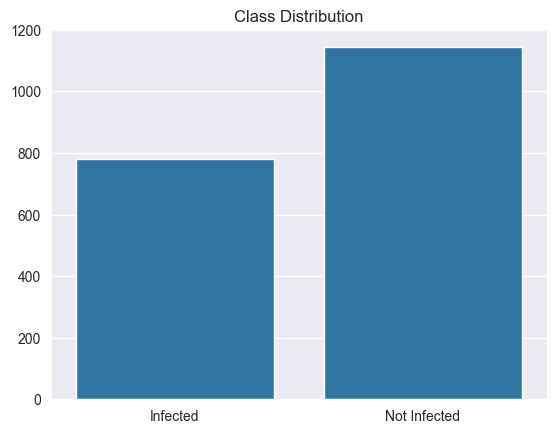

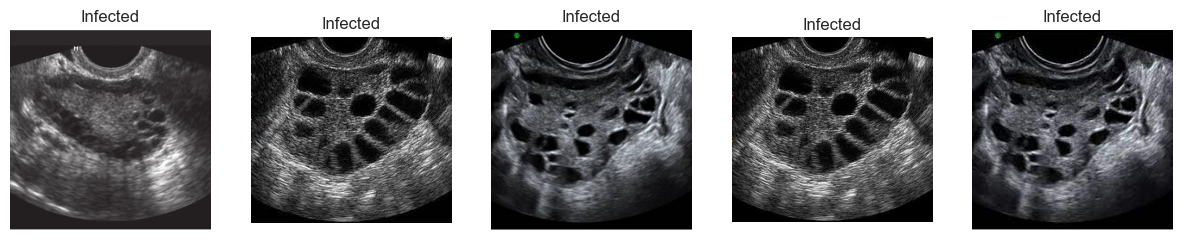

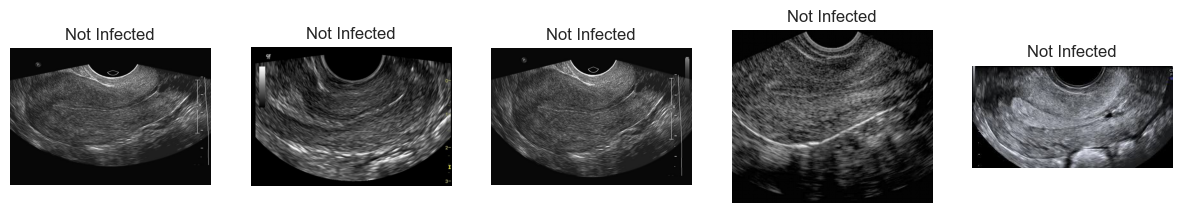

Unique sizes in infected: {(225, 225), (233, 216), (343, 343), (280, 259), (299, 266), (320, 320), (300, 300)}
Unique sizes in not infected: {(315, 160), (630, 436), (850, 578), (984, 848)}


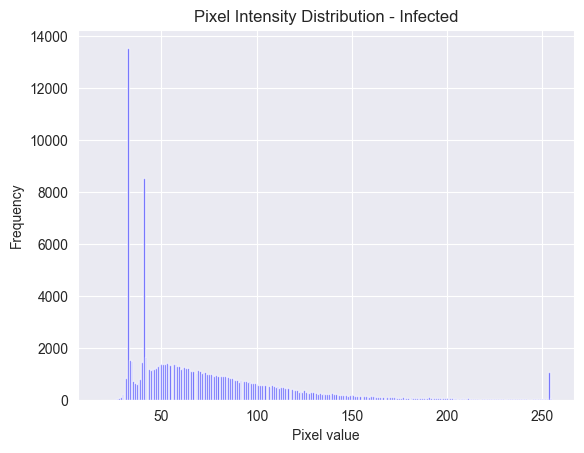

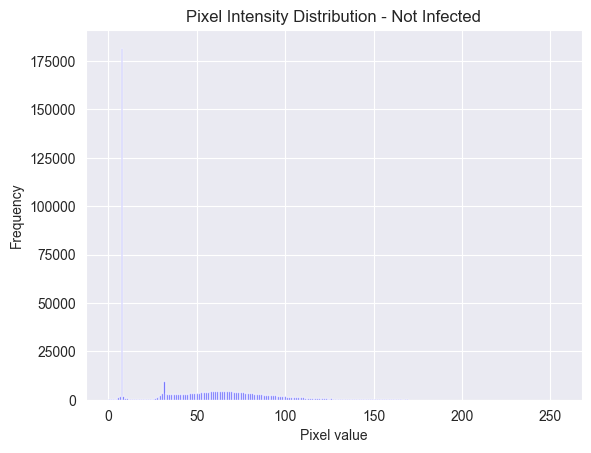

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from collections import Counter
import seaborn as sns

# Path setup (relative to your .ipynb location)
infected_dir = '../data/archive/data/train/infected'
notinfected_dir = '../data/archive/data/train/notinfected'

infected_images = os.listdir(infected_dir)
notinfected_images = os.listdir(notinfected_dir)

print(f"Infected images: {len(infected_images)}")
print(f"Not infected images: {len(notinfected_images)}")

# Class distribution visualization
sns.barplot(x=['Infected', 'Not Infected'], y=[len(infected_images), len(notinfected_images)])
plt.title("Class Distribution")
plt.show()

# Randomly display sample images
def show_images(image_paths, label, n=5):
    plt.figure(figsize=(15, 3))
    for i in range(n):
        img = Image.open(image_paths[i])
        plt.subplot(1, n, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(label)
        plt.axis('off')
    plt.show()

show_images([os.path.join(infected_dir, f) for f in infected_images[:5]], "Infected")
show_images([os.path.join(notinfected_dir, f) for f in notinfected_images[:5]], "Not Infected")

# Analyze image sizes
def get_image_sizes(image_paths, sample_size=100):
    sizes = []
    for path in image_paths[:sample_size]:
        try:
            img = Image.open(path)
            sizes.append(img.size)
        except:
            pass
    return sizes

infected_sizes = get_image_sizes([os.path.join(infected_dir, f) for f in infected_images])
notinfected_sizes = get_image_sizes([os.path.join(notinfected_dir, f) for f in notinfected_images])

print(f"Unique sizes in infected: {set(infected_sizes)}")
print(f"Unique sizes in not infected: {set(notinfected_sizes)}")

# Pixel value distribution
def plot_pixel_distribution(img_path, title):
    img = Image.open(img_path).convert('L')
    img_array = np.array(img)
    plt.hist(img_array.ravel(), bins=256, color='blue', alpha=0.7)
    plt.title(f'Pixel Intensity Distribution - {title}')
    plt.xlabel('Pixel value')
    plt.ylabel('Frequency')
    plt.show()

plot_pixel_distribution(os.path.join(infected_dir, infected_images[0]), "Infected")
plot_pixel_distribution(os.path.join(notinfected_dir, notinfected_images[0]), "Not Infected")


In [2]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from skimage.feature import graycomatrix, graycoprops
import cv2
from tqdm import tqdm

# Image directory paths (relative to your notebook)
infected_dir = '../data/archive/data/train/infected'
notinfected_dir = '../data/archive/data/train/notinfected'

# Feature extraction function
def extract_features(image_path):
    try:
        img = Image.open(image_path).convert('L').resize((64, 64))
        arr = np.array(img)

        # Grayscale statistics
        mean = arr.mean()
        std = arr.std()

        # Haralick texture features
        glcm = graycomatrix(arr, [1], [0], symmetric=True, normed=True)
        contrast = graycoprops(glcm, 'contrast')[0, 0]
        energy = graycoprops(glcm, 'energy')[0, 0]
        homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]

        # Canny edge features
        edges = cv2.Canny(arr, 100, 200)
        edge_count = np.sum(edges > 0)

        # Pixel histogram
        hist, _ = np.histogram(arr, bins=32, range=(0, 256))
        hist = hist / np.sum(hist)

        features = [mean, std, contrast, energy, homogeneity, edge_count]
        features.extend(hist.tolist())

        return features
    except Exception as e:
        print(f"Failed on {image_path} with error: {e}")
        return None

# Define column names
feature_names = ['mean', 'std', 'contrast', 'energy', 'homogeneity', 'edge_count']
hist_names = [f'hist_bin_{i}' for i in range(32)]
columns = feature_names + hist_names + ['label']

# Collect data
data = []

for f in tqdm(os.listdir(infected_dir), desc='Processing infected'):
    path = os.path.join(infected_dir, f)
    feats = extract_features(path)
    if feats is not None:
        data.append(feats + [1])

for f in tqdm(os.listdir(notinfected_dir), desc='Processing not infected'):
    path = os.path.join(notinfected_dir, f)
    feats = extract_features(path)
    if feats is not None:
        data.append(feats + [0])

# Convert to DataFrame
df = pd.DataFrame(data, columns=columns)
print("✅ Extraction complete, data shape:", df.shape)
print(df.head())


Processing not infected: 100%|██████████| 1143/1143 [00:05<00:00, 199.43it/s]

✅ Extraction complete, data shape: (1924, 39)
        mean        std    contrast    energy  homogeneity  edge_count  \
0  73.774902  37.801375  231.967758  0.086543     0.288315         818   
1  61.711914  43.284488  406.496528  0.049063     0.146974        1149   
2  56.214355  45.848713  478.101190  0.094878     0.235090        1058   
3  60.672852  43.223370  397.086558  0.065185     0.160974        1146   
4  56.600586  45.695019  484.603919  0.081907     0.222189        1033   

   hist_bin_0  hist_bin_1  hist_bin_2  hist_bin_3  ...  hist_bin_23  \
0    0.000000    0.000000    0.000000    0.032227  ...     0.004639   
1    0.132568    0.057373    0.048340    0.050781  ...     0.003662   
2    0.179932    0.048584    0.066650    0.085693  ...     0.002441   
3    0.142578    0.054443    0.046631    0.051514  ...     0.002930   
4    0.176758    0.051758    0.064941    0.055664  ...     0.002197   

   hist_bin_24  hist_bin_25  hist_bin_26  hist_bin_27  hist_bin_28  \
0     0.0031

In [3]:
# View the first few rows of the data (to confirm it's not empty)
print(df.head())

# Check the total number of rows and columns
print(df.shape)

# Check data types of each column and whether there are missing values
print(df.info())

# Check the label distribution (0 = not infected, 1 = infected)
print(df['label'].value_counts())


        mean        std    contrast    energy  homogeneity  edge_count  \
0  73.774902  37.801375  231.967758  0.086543     0.288315         818   
1  61.711914  43.284488  406.496528  0.049063     0.146974        1149   
2  56.214355  45.848713  478.101190  0.094878     0.235090        1058   
3  60.672852  43.223370  397.086558  0.065185     0.160974        1146   
4  56.600586  45.695019  484.603919  0.081907     0.222189        1033   

   hist_bin_0  hist_bin_1  hist_bin_2  hist_bin_3  ...  hist_bin_23  \
0    0.000000    0.000000    0.000000    0.032227  ...     0.004639   
1    0.132568    0.057373    0.048340    0.050781  ...     0.003662   
2    0.179932    0.048584    0.066650    0.085693  ...     0.002441   
3    0.142578    0.054443    0.046631    0.051514  ...     0.002930   
4    0.176758    0.051758    0.064941    0.055664  ...     0.002197   

   hist_bin_24  hist_bin_25  hist_bin_26  hist_bin_27  hist_bin_28  \
0     0.003174     0.002686     0.001465      0.00293     

In [4]:
print(df.shape)
print(df.isnull().sum())
print(df['mean'].describe())
print(df['label'].value_counts())


(1924, 39)
mean           0
std            0
contrast       0
energy         0
homogeneity    0
edge_count     0
hist_bin_0     0
hist_bin_1     0
hist_bin_2     0
hist_bin_3     0
hist_bin_4     0
hist_bin_5     0
hist_bin_6     0
hist_bin_7     0
hist_bin_8     0
hist_bin_9     0
hist_bin_10    0
hist_bin_11    0
hist_bin_12    0
hist_bin_13    0
hist_bin_14    0
hist_bin_15    0
hist_bin_16    0
hist_bin_17    0
hist_bin_18    0
hist_bin_19    0
hist_bin_20    0
hist_bin_21    0
hist_bin_22    0
hist_bin_23    0
hist_bin_24    0
hist_bin_25    0
hist_bin_26    0
hist_bin_27    0
hist_bin_28    0
hist_bin_29    0
hist_bin_30    0
hist_bin_31    0
label          0
dtype: int64
count    1924.000000
mean       61.196363
std        18.164011
min        35.161133
25%        47.249023
50%        55.661011
75%        72.326477
max       141.651611
Name: mean, dtype: float64
label
0    1143
1     781
Name: count, dtype: int64


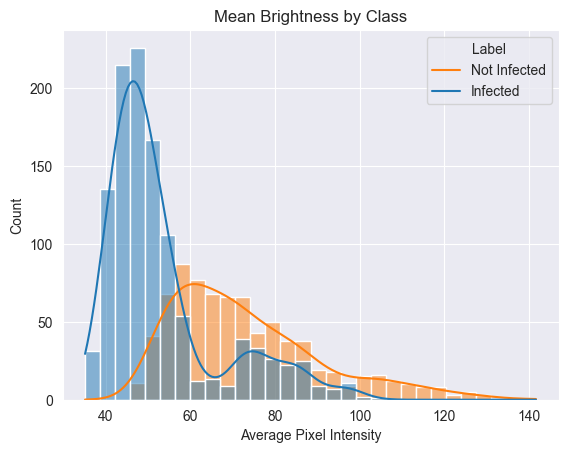

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data=df, x='mean', hue='label', bins=30, kde=True)
plt.title("Mean Brightness by Class")
plt.xlabel("Average Pixel Intensity")
plt.ylabel("Count")
plt.legend(title='Label', labels=['Not Infected', 'Infected'])
plt.savefig("mean_brightness_hist.png")
plt.show()


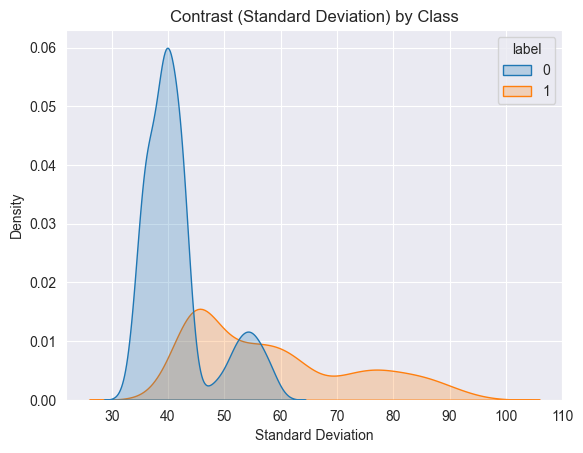

In [6]:
sns.kdeplot(data=df, x='std', hue='label', fill=True)
plt.title("Contrast (Standard Deviation) by Class")
plt.xlabel("Standard Deviation")
plt.savefig("std_kde_plot.png")
plt.show()


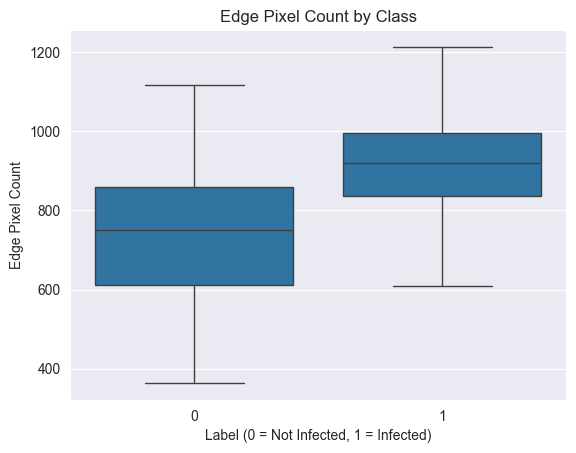

In [7]:
sns.boxplot(data=df, x='label', y='edge_count')
plt.title("Edge Pixel Count by Class")
plt.xlabel("Label (0 = Not Infected, 1 = Infected)")
plt.ylabel("Edge Pixel Count")
plt.savefig("edge_count_boxplot.png")
plt.show()


D:\Users\Kaiyang\anaconda3\envs\ML_DL\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "D:\Users\Kaiyang\anaconda3\envs\ML_DL\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "D:\Users\Kaiyang\anaconda3\envs\ML_DL\lib\subprocess.py", line 505, in run
    with Popen(*popenargs, **kwargs) as process:
  File "D:\Users\Kaiyang\anaconda3\envs\ML_DL\lib\subprocess.py", line 951, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "D:\Users\Kaiyang\anaconda3\envs\ML_DL\lib\subprocess.py", line 1436, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess

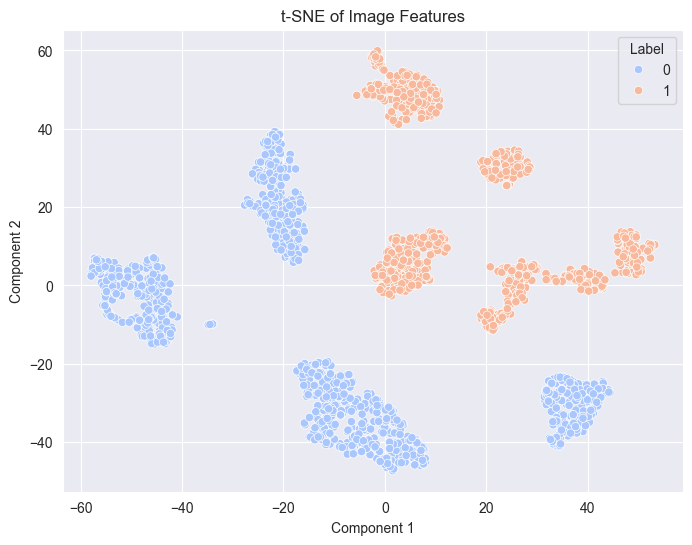

In [8]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Drop the label column for dimensionality reduction
X = df.drop(columns=['label'])
y = df['label']

# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X_scaled)

# Visualization
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y, palette="coolwarm")
plt.title("t-SNE of Image Features")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Label")
plt.savefig("tsne_plot.png")
plt.show()


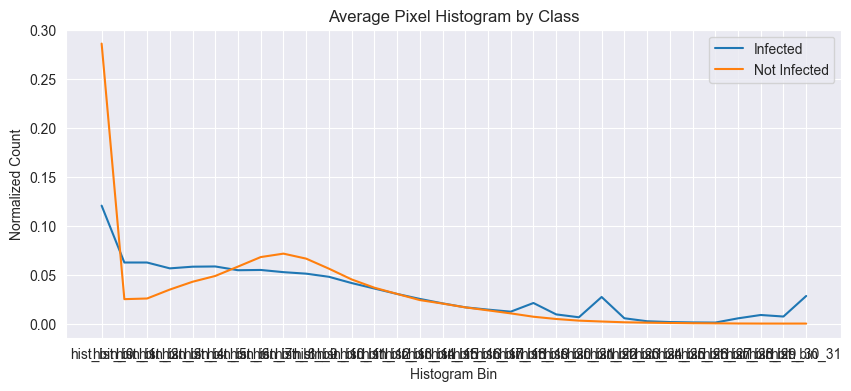

In [9]:
# Pixel histogram per class (mean histogram)
import matplotlib.pyplot as plt
import numpy as np

infected_hist = df[df['label'] == 1].loc[:, 'hist_bin_0':'hist_bin_31'].mean()
notinfected_hist = df[df['label'] == 0].loc[:, 'hist_bin_0':'hist_bin_31'].mean()

plt.figure(figsize=(10, 4))
plt.plot(infected_hist, label='Infected')
plt.plot(notinfected_hist, label='Not Infected')
plt.title("Average Pixel Histogram by Class")
plt.xlabel("Histogram Bin")
plt.ylabel("Normalized Count")
plt.legend()
plt.savefig("pixel_histogram_plot.png")
plt.show()



In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

In [11]:
# Assuming 'df' DataFrame exists from your feature extraction
print("Original DataFrame shape:", df.shape)

# Separate features (X) and target (y)
X = df.drop(columns=['label'])
y = df['label']

# Train-Test Split (80% train, 20% test)
# stratify=y ensures balanced classes in splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set shape: X={X_train.shape}, y={y_train.shape}")
print(f"Testing set shape: X={X_test.shape}, y={y_test.shape}")

print("\nTraining set label distribution:")
print(y_train.value_counts(normalize=True))
print("\nTesting set label distribution:")
print(y_test.value_counts(normalize=True))

Original DataFrame shape: (1924, 39)

Training set shape: X=(1539, 38), y=(1539,)
Testing set shape: X=(385, 38), y=(385,)

Training set label distribution:
label
0    0.593892
1    0.406108
Name: proportion, dtype: float64

Testing set label distribution:
label
0    0.594805
1    0.405195
Name: proportion, dtype: float64


In [12]:
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler ONLY on the training data
scaler.fit(X_train)

# Apply the scaler to both training and testing data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("--- Data Scaled ---")
# You can optionally check the mean/std of the scaled data
# print("Scaled training data mean (should be close to 0):", X_train_scaled.mean(axis=0)[:5])
# print("Scaled training data std dev (should be close to 1):", X_train_scaled.std(axis=0)[:5])

--- Data Scaled ---


In [13]:
print("\n--- Training Logistic Regression ---")
# Initialize and train the model
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

# Make predictions
y_pred_lr = log_reg.predict(X_test_scaled)
y_prob_lr = log_reg.predict_proba(X_test_scaled)[:, 1] # Get probabilities for the positive class for AUC

# Evaluate the model
print("\n--- Logistic Regression Evaluation ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"AUC Score: {roc_auc_score(y_test, y_prob_lr):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))


--- Training Logistic Regression ---

--- Logistic Regression Evaluation ---
Accuracy: 0.9948
AUC Score: 0.9927

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       229
           1       1.00      0.99      0.99       156

    accuracy                           0.99       385
   macro avg       1.00      0.99      0.99       385
weighted avg       0.99      0.99      0.99       385


Confusion Matrix:
 [[229   0]
 [  2 154]]


In [14]:
import pandas as pd

# --- Error Analysis for Logistic Regression ---

# Ensure y_test and y_pred_lr exist from the previous Logistic Regression evaluation cell

# Find the indices in the original DataFrame 'df' that correspond to the test set samples
test_indices = y_test.index

# Find the indices within the test set where the prediction was wrong
misclassified_indices_in_test = test_indices[y_test != y_pred_lr]

print(f"\n--- Misclassified Samples by Logistic Regression ---")
print(f"Number of misclassified samples in the test set: {len(misclassified_indices_in_test)}")

if not misclassified_indices_in_test.empty:
    print("\nIndices of misclassified samples (in the original DataFrame):")
    print(misclassified_indices_in_test.tolist())

    # Display the original features and TRUE labels of the misclassified samples
    print("\nFeatures and true labels of misclassified samples:")
    # Use .loc to select rows from the original df using the indices
    print(df.loc[misclassified_indices_in_test])

    # You could also add code here to display the actual images corresponding
    # to these indices if you have stored the file paths in order,
    # but that requires linking the df index back to the original file lists.
else:
    print("\nNo samples were misclassified by Logistic Regression in this test set.")


--- Misclassified Samples by Logistic Regression ---
Number of misclassified samples in the test set: 2

Indices of misclassified samples (in the original DataFrame):
[6, 0]

Features and true labels of misclassified samples:
        mean        std    contrast    energy  homogeneity  edge_count  \
6  73.831299  37.795232  231.142857  0.086431     0.289385         848   
0  73.774902  37.801375  231.967758  0.086543     0.288315         818   

   hist_bin_0  hist_bin_1  hist_bin_2  hist_bin_3  ...  hist_bin_23  \
6         0.0         0.0         0.0    0.032715  ...     0.003906   
0         0.0         0.0         0.0    0.032227  ...     0.004639   

   hist_bin_24  hist_bin_25  hist_bin_26  hist_bin_27  hist_bin_28  \
6     0.003418     0.003174     0.001221     0.001953     0.001221   
0     0.003174     0.002686     0.001465     0.002930     0.000732   

   hist_bin_29  hist_bin_30  hist_bin_31  label  
6     0.000244     0.000732     0.000244      1  
0     0.000244     0.0004

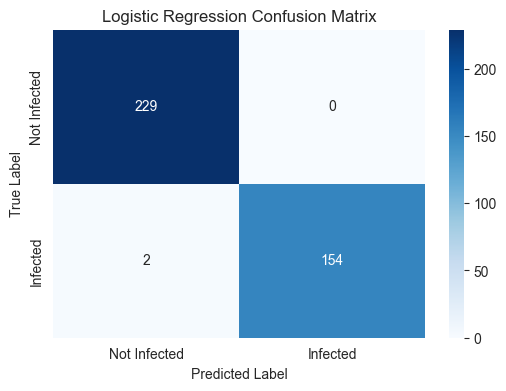

In [15]:
# Visualize the confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6,4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Infected', 'Infected'],
            yticklabels=['Not Infected', 'Infected'])
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [16]:
print("\n--- Training Random Forest ---")
# Initialize and train the model
rf_clf = RandomForestClassifier(random_state=42, n_estimators=100) # Start with 100 trees
rf_clf.fit(X_train_scaled, y_train)

# Make predictions
y_pred_rf = rf_clf.predict(X_test_scaled)
y_prob_rf = rf_clf.predict_proba(X_test_scaled)[:, 1] # Probabilities for AUC

# Evaluate the model
print("\n--- Random Forest Evaluation ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"AUC Score: {roc_auc_score(y_test, y_prob_rf):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


--- Training Random Forest ---

--- Random Forest Evaluation ---
Accuracy: 1.0000
AUC Score: 1.0000

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       229
           1       1.00      1.00      1.00       156

    accuracy                           1.00       385
   macro avg       1.00      1.00      1.00       385
weighted avg       1.00      1.00      1.00       385


Confusion Matrix:
 [[229   0]
 [  0 156]]


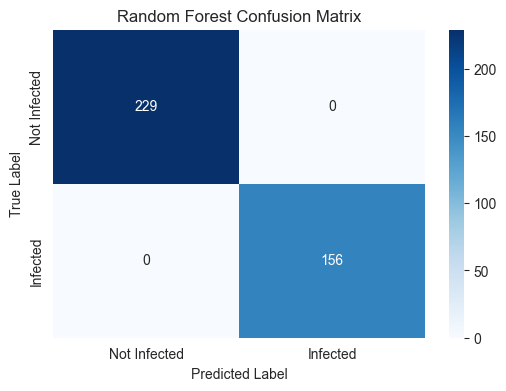

In [17]:
# Visualize the confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6,4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Infected', 'Infected'],
            yticklabels=['Not Infected', 'Infected'])
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [18]:
print("\n--- Random Forest Feature Importances ---")
# Check if the model has feature_importances_ attribute
if hasattr(rf_clf, 'feature_importances_'):
    importances = rf_clf.feature_importances_
    feature_names = X.columns # Get feature names from the original X dataframe
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    print("Top 10 Features:")
    print(feature_importance_df.head(10))
else:
    print("Feature importances not available for this model.")
    feature_importance_df = None # Set to None if not available for the next cell


--- Random Forest Feature Importances ---
Top 10 Features:
        Feature  Importance
25  hist_bin_19    0.112843
24  hist_bin_18    0.103165
26  hist_bin_20    0.100853
23  hist_bin_17    0.078972
1           std    0.078879
27  hist_bin_21    0.060692
22  hist_bin_16    0.060059
21  hist_bin_15    0.052948
7    hist_bin_1    0.039315
20  hist_bin_14    0.038218


In [19]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Assuming 'df' DataFrame exists from your feature extraction
print("Using DataFrame with shape:", df.shape)

# Separate features (X) and target (y) - Use the full dataset
X = df.drop(columns=['label'])
y = df['label']

# Scale the entire feature set before cross-validation
# Note: In a strict workflow, scaling would happen within each CV fold
# to prevent data leakage from the test fold into the scaling parameters.
# However, for simplicity and given the high performance seen, we'll scale upfront first.
# For a more rigorous approach, use scikit-learn Pipelines with cross_val_score.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("--- Full dataset scaled ---")

# Define the cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print(f"--- Using {cv_strategy.get_n_splits()}-Fold Stratified Cross-Validation ---")

Using DataFrame with shape: (1924, 39)
--- Full dataset scaled ---
--- Using 5-Fold Stratified Cross-Validation ---


In [20]:
print("\n--- Cross-Validating Logistic Regression ---")

# Initialize the model
log_reg_cv = LogisticRegression(random_state=42, max_iter=1000)

# Perform cross-validation for Accuracy
cv_scores_acc_lr = cross_val_score(log_reg_cv, X_scaled, y, cv=cv_strategy, scoring='accuracy')

# Perform cross-validation for AUC
cv_scores_auc_lr = cross_val_score(log_reg_cv, X_scaled, y, cv=cv_strategy, scoring='roc_auc')


print("\n--- Logistic Regression CV Results ---")
print(f"Accuracy Scores for each fold: {cv_scores_acc_lr}")
print(f"Mean Accuracy: {np.mean(cv_scores_acc_lr):.4f}")
print(f"Standard Deviation Accuracy: {np.std(cv_scores_acc_lr):.4f}")

print(f"\nAUC Scores for each fold: {cv_scores_auc_lr}")
print(f"Mean AUC: {np.mean(cv_scores_auc_lr):.4f}")
print(f"Standard Deviation AUC: {np.std(cv_scores_auc_lr):.4f}")


--- Cross-Validating Logistic Regression ---

--- Logistic Regression CV Results ---
Accuracy Scores for each fold: [1.        0.9974026 1.        0.9974026 1.       ]
Mean Accuracy: 0.9990
Standard Deviation Accuracy: 0.0013

AUC Scores for each fold: [1. 1. 1. 1. 1.]
Mean AUC: 1.0000
Standard Deviation AUC: 0.0000


In [21]:
print("\n--- Cross-Validating Random Forest ---")

# Initialize the model
rf_clf_cv = RandomForestClassifier(random_state=42, n_estimators=100)

# Perform cross-validation for Accuracy
cv_scores_acc_rf = cross_val_score(rf_clf_cv, X_scaled, y, cv=cv_strategy, scoring='accuracy')

# Perform cross-validation for AUC
cv_scores_auc_rf = cross_val_score(rf_clf_cv, X_scaled, y, cv=cv_strategy, scoring='roc_auc')


print("\n--- Random Forest CV Results ---")
print(f"Accuracy Scores for each fold: {cv_scores_acc_rf}")
print(f"Mean Accuracy: {np.mean(cv_scores_acc_rf):.4f}")
print(f"Standard Deviation Accuracy: {np.std(cv_scores_acc_rf):.4f}")

print(f"\nAUC Scores for each fold: {cv_scores_auc_rf}")
print(f"Mean AUC: {np.mean(cv_scores_auc_rf):.4f}")
print(f"Standard Deviation AUC: {np.std(cv_scores_auc_rf):.4f}")


--- Cross-Validating Random Forest ---

--- Random Forest CV Results ---
Accuracy Scores for each fold: [1. 1. 1. 1. 1.]
Mean Accuracy: 1.0000
Standard Deviation Accuracy: 0.0000

AUC Scores for each fold: [1. 1. 1. 1. 1.]
Mean AUC: 1.0000
Standard Deviation AUC: 0.0000


In [22]:
import pandas as pd

# --- Error Analysis for Logistic Regression ---

# Ensure y_test and y_pred_lr exist from the previous Logistic Regression evaluation cell

# Find the indices in the original DataFrame 'df' that correspond to the test set samples
test_indices = y_test.index

# Find the indices within the test set where the prediction was wrong
misclassified_indices_in_test = test_indices[y_test != y_pred_lr]

print(f"\n--- Misclassified Samples by Logistic Regression ---")
print(f"Number of misclassified samples in the test set: {len(misclassified_indices_in_test)}")

if not misclassified_indices_in_test.empty:
    print("\nIndices of misclassified samples (in the original DataFrame):")
    print(misclassified_indices_in_test.tolist())

    # Display the original features and TRUE labels of the misclassified samples
    print("\nFeatures and true labels of misclassified samples:")
    # Use .loc to select rows from the original df using the indices
    print(df.loc[misclassified_indices_in_test])

    # You could also add code here to display the actual images corresponding
    # to these indices if you have stored the file paths in order,
    # but that requires linking the df index back to the original file lists.
else:
    print("\nNo samples were misclassified by Logistic Regression in this test set.")


--- Misclassified Samples by Logistic Regression ---
Number of misclassified samples in the test set: 2

Indices of misclassified samples (in the original DataFrame):
[6, 0]

Features and true labels of misclassified samples:
        mean        std    contrast    energy  homogeneity  edge_count  \
6  73.831299  37.795232  231.142857  0.086431     0.289385         848   
0  73.774902  37.801375  231.967758  0.086543     0.288315         818   

   hist_bin_0  hist_bin_1  hist_bin_2  hist_bin_3  ...  hist_bin_23  \
6         0.0         0.0         0.0    0.032715  ...     0.003906   
0         0.0         0.0         0.0    0.032227  ...     0.004639   

   hist_bin_24  hist_bin_25  hist_bin_26  hist_bin_27  hist_bin_28  \
6     0.003418     0.003174     0.001221     0.001953     0.001221   
0     0.003174     0.002686     0.001465     0.002930     0.000732   

   hist_bin_29  hist_bin_30  hist_bin_31  label  
6     0.000244     0.000732     0.000244      1  
0     0.000244     0.0004


Displaying the 2 images misclassified by Logistic Regression:
Image 1 (Index 0): img1.jpg
Image 2 (Index 6): img6.jpg


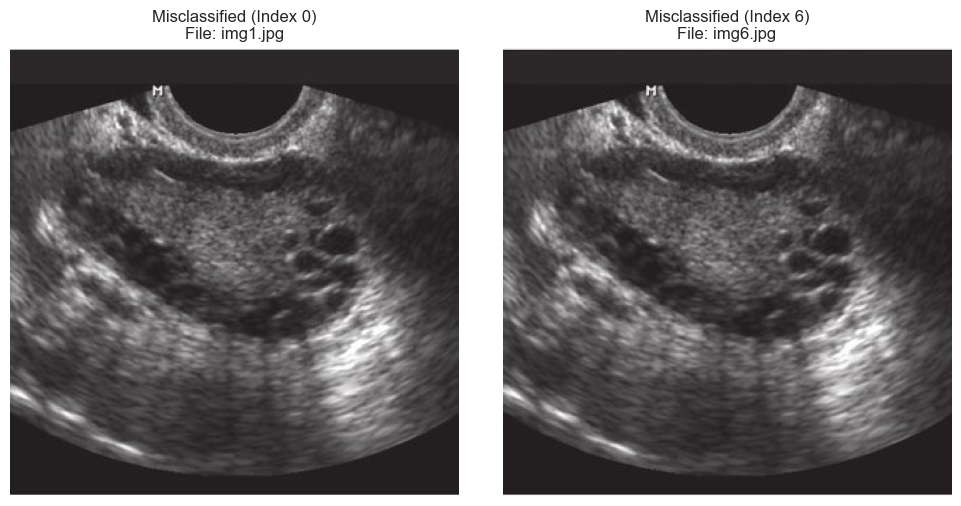

In [23]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# --- Display Misclassified Images ---

# Indices from the error analysis output (corresponding to rows in df)
misclassified_df_indices = [0, 6]

# Assuming 'infected_images' list and 'infected_dir' path are available from your first cell
if 'infected_images' in locals() and 'infected_dir' in locals():
    # Get the filenames based on the df indices (which match the order they were added)
    # NOTE: This relies on the order of processing during feature extraction
    # where infected images were processed first.
    misclassified_filenames = [infected_images[i] for i in misclassified_df_indices]
    misclassified_paths = [os.path.join(infected_dir, fname) for fname in misclassified_filenames]

    print("\nDisplaying the 2 images misclassified by Logistic Regression:")
    print(f"Image 1 (Index {misclassified_df_indices[0]}): {misclassified_filenames[0]}")
    print(f"Image 2 (Index {misclassified_df_indices[1]}): {misclassified_filenames[1]}")

    plt.figure(figsize=(10, 5)) # Adjust figure size as needed

    # Display first misclassified image
    try:
        img1 = Image.open(misclassified_paths[0])
        plt.subplot(1, 2, 1) # 1 row, 2 columns, 1st plot
        plt.imshow(img1, cmap='gray')
        plt.title(f"Misclassified (Index {misclassified_df_indices[0]})\nFile: {misclassified_filenames[0]}")
        plt.axis('off')
    except Exception as e:
        print(f"Error opening/displaying {misclassified_filenames[0]}: {e}")
        plt.subplot(1, 2, 1)
        plt.title(f"Error loading {misclassified_filenames[0]}")
        plt.axis('off')


    # Display second misclassified image
    try:
        img2 = Image.open(misclassified_paths[1])
        plt.subplot(1, 2, 2) # 1 row, 2 columns, 2nd plot
        plt.imshow(img2, cmap='gray')
        plt.title(f"Misclassified (Index {misclassified_df_indices[1]})\nFile: {misclassified_filenames[1]}")
        plt.axis('off')
    except Exception as e:
        print(f"Error opening/displaying {misclassified_filenames[1]}: {e}")
        plt.subplot(1, 2, 2)
        plt.title(f"Error loading {misclassified_filenames[1]}")
        plt.axis('off')


    plt.tight_layout()
    plt.show()

else:
    print("Error: 'infected_dir' or 'infected_images' list not found.")
    print("Please ensure the first cell defining these variables has been run.")

In [24]:
import numpy as np
import pandas as pd

# Indices of misclassified samples from your previous output
misclassified_df_indices = [0, 6]

# Ensure X_test_scaled, log_reg, rf_clf, test_indices exist

# Get the scaled features for these specific samples
# We need to find their location within the X_test_scaled array
# First, get the original index values of X_test
original_test_indices = X_test.index.tolist()

# Find the positional indices within X_test_scaled corresponding to df indices 0 and 6
positions_in_test_scaled = [original_test_indices.index(idx) for idx in misclassified_df_indices if idx in original_test_indices]

if positions_in_test_scaled:
    misclassified_X_scaled = X_test_scaled[positions_in_test_scaled]

    # Get probabilities from Logistic Regression (Prob of being Not Infected, Prob of being Infected)
    probs_lr = log_reg.predict_proba(misclassified_X_scaled)

    # Get probabilities from Random Forest
    probs_rf = rf_clf.predict_proba(misclassified_X_scaled)

    print("\n--- Predicted Probabilities for Misclassified Samples (Indices 0, 6) ---")
    for i, original_idx in enumerate(misclassified_df_indices):
         if original_idx in original_test_indices:
            print(f"\nSample with Original Index: {original_idx} (True Label: 1)")
            print(f"  Logistic Regression Probabilities [P(0), P(1)]: [{probs_lr[i][0]:.4f}, {probs_lr[i][1]:.4f}]")
            print(f"  Random Forest Probabilities       [P(0), P(1)]: [{probs_rf[i][0]:.4f}, {probs_rf[i][1]:.4f}]")
            print(f"  Logistic Regression Prediction: {log_reg.predict(misclassified_X_scaled[i:i+1])[0]}") # Should be 0
            print(f"  Random Forest Prediction:       {rf_clf.predict(misclassified_X_scaled[i:i+1])[0]}") # Should be 1
else:
    print("Could not find the misclassified samples in the current test set split. Indices might differ.")


--- Predicted Probabilities for Misclassified Samples (Indices 0, 6) ---

Sample with Original Index: 0 (True Label: 1)
  Logistic Regression Probabilities [P(0), P(1)]: [0.9990, 0.0010]
  Random Forest Probabilities       [P(0), P(1)]: [0.3000, 0.7000]
  Logistic Regression Prediction: 0
  Random Forest Prediction:       1

Sample with Original Index: 6 (True Label: 1)
  Logistic Regression Probabilities [P(0), P(1)]: [0.9979, 0.0021]
  Random Forest Probabilities       [P(0), P(1)]: [0.3400, 0.6600]
  Logistic Regression Prediction: 0
  Random Forest Prediction:       1


In [25]:
# Ensure df, test_indices, misclassified_df_indices, y_test, y_pred_lr, feature_importance_df exist

print("\n--- Feature Comparison for Misclassified Samples ---")

# Get correctly classified infected samples from the test set
correct_infected_indices = test_indices[(y_test == 1) & (y_pred_lr == 1)] # Correctly classified as Infected by LR

# Get not infected samples from the test set (all were correctly classified by LR)
not_infected_indices = test_indices[y_test == 0]

# Get the top N features from Random Forest importance
top_features = feature_importance_df['Feature'].head(10).tolist() # Look at top 10 features

# Calculate mean feature values for comparison
mean_misclassified = df.loc[misclassified_df_indices, top_features].mean()
mean_correct_infected = df.loc[correct_infected_indices, top_features].mean()
mean_not_infected = df.loc[not_infected_indices, top_features].mean()

# Create a comparison DataFrame
comparison_df = pd.DataFrame({
    'Misclassified (Avg)': mean_misclassified,
    'Correctly Infected (Avg)': mean_correct_infected,
    'Not Infected (Avg)': mean_not_infected
})

print("\nAverage values of top 10 features for different groups:")
print(comparison_df)

print("\nFeatures of the two misclassified samples:")
print(df.loc[misclassified_df_indices, top_features + ['label']])


--- Feature Comparison for Misclassified Samples ---

Average values of top 10 features for different groups:
             Misclassified (Avg)  Correctly Infected (Avg)  Not Infected (Avg)
hist_bin_19             0.008667                  0.019956            0.007734
hist_bin_18             0.010620                  0.011603            0.011607
hist_bin_20             0.007080                  0.008998            0.005248
hist_bin_17             0.017700                  0.013819            0.015031
std                    37.798304                 59.372286           42.015294
hist_bin_21             0.007202                  0.006284            0.003239
hist_bin_16             0.018921                  0.016145            0.017838
hist_bin_15             0.023438                  0.019883            0.021618
hist_bin_1              0.000000                  0.064732            0.026397
hist_bin_14             0.028198                  0.024902            0.025135

Features of the two

In [26]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm # Make sure tqdm is imported

# --- Evaluate Feature-Based Models on TEST Set ---

# Define paths for the TEST data
test_infected_dir = '../data/archive/data/test/infected'
test_notinfected_dir = '../data/archive/data/test/notinfected'

# Ensure the extract_features function from earlier in your notebook is defined and available!
# Also ensure necessary libraries like cv2, skimage are imported if needed by the function.

print("\n--- Extracting features from TEST data ---")
test_data = []
test_labels_list = [] # Keep track of labels for evaluation

# Check if test directories exist
if not os.path.isdir(test_infected_dir):
    print(f"Error: Test directory not found - {test_infected_dir}")
if not os.path.isdir(test_notinfected_dir):
    print(f"Error: Test directory not found - {test_notinfected_dir}")

test_feature_extraction_possible = os.path.isdir(test_infected_dir) and os.path.isdir(test_notinfected_dir)

if test_feature_extraction_possible:
    # Process infected test images
    for f in tqdm(os.listdir(test_infected_dir), desc='Processing test infected'):
        path = os.path.join(test_infected_dir, f)
        if os.path.isfile(path):
            # Assuming extract_features is defined and returns a list of features
            feats = extract_features(path)
            if feats is not None:
                test_data.append(feats)
                test_labels_list.append(1) # Label 1 for infected

    # Process not infected test images
    for f in tqdm(os.listdir(test_notinfected_dir), desc='Processing test not infected'):
        path = os.path.join(test_notinfected_dir, f)
        if os.path.isfile(path):
             # Assuming extract_features is defined and returns a list of features
            feats = extract_features(path)
            if feats is not None:
                test_data.append(feats)
                test_labels_list.append(0) # Label 0 for not infected

    if test_data:
        # Get feature names (excluding label) - should match training
        feature_names_only = feature_names # Assumes 'feature_names' from your training code is available
        df_test_features = pd.DataFrame(test_data, columns=feature_names_only)
        y_test_actual = pd.Series(test_labels_list) # True labels for the test set
        print(f"\nTest feature extraction complete. Test data shape: {df_test_features.shape}")
    else:
        print("\nNo test data extracted. Check paths or extraction function.")
        test_feature_extraction_possible = False
else:
    print("\nSkipping test set evaluation for feature models due to missing directories.")


--- Extracting features from TEST data ---


Processing test infected: 100%|██████████| 787/787 [00:03<00:00, 231.35it/s]


Failed on ../data/archive/data/test/infected\OIP.jpg with error: cannot identify image file '../data/archive/data/test/infected\\OIP.jpg'
Failed on ../data/archive/data/test/infected\R.jpg with error: cannot identify image file '../data/archive/data/test/infected\\R.jpg'
Failed on ../data/archive/data/test/infected\WhatsApp Image 2022-04-01 at 3.49.22 PM.jpeg with error: cannot identify image file '../data/archive/data/test/infected\\WhatsApp Image 2022-04-01 at 3.49.22 PM.jpeg'
Failed on ../data/archive/data/test/infected\WhatsApp Image 2022-04-01 at 3.49.45 PM.jpeg with error: cannot identify image file '../data/archive/data/test/infected\\WhatsApp Image 2022-04-01 at 3.49.45 PM.jpeg'
Failed on ../data/archive/data/test/infected\WhatsApp Image 2022-04-01 at 3.50.05 PM.jpeg with error: cannot identify image file '../data/archive/data/test/infected\\WhatsApp Image 2022-04-01 at 3.50.05 PM.jpeg'
Failed on ../data/archive/data/test/infected\WhatsApp Image 2022-04-01 at 3.50.20 PM.jpeg wi

Processing test not infected:  69%|██████▉   | 790/1145 [00:04<00:01, 186.24it/s]

Failed on ../data/archive/data/test/notinfected\img_0_7.jpg with error: cannot identify image file '../data/archive/data/test/notinfected\\img_0_7.jpg'


Processing test not infected: 100%|██████████| 1145/1145 [00:06<00:00, 185.61it/s]

Failed on ../data/archive/data/test/notinfected\OIP (1).jpg with error: cannot identify image file '../data/archive/data/test/notinfected\\OIP (1).jpg'
Failed on ../data/archive/data/test/notinfected\WhatsApp Image 2022-04-01 at 3.35.25 PM.jpeg with error: cannot identify image file '../data/archive/data/test/notinfected\\WhatsApp Image 2022-04-01 at 3.35.25 PM.jpeg'
Failed on ../data/archive/data/test/notinfected\WhatsApp Image 2022-04-01 at 3.39.07 PM.jpeg with error: cannot identify image file '../data/archive/data/test/notinfected\\WhatsApp Image 2022-04-01 at 3.39.07 PM.jpeg'

Test feature extraction complete. Test data shape: (1922, 38)



--- Scaling test features ---
Test features scaled.

--- Evaluating Logistic Regression on Actual Test Set ---
Test Accuracy: 0.9990
Test AUC Score: 0.9988

Test Classification Report:
               precision    recall  f1-score   support

Not Infected       1.00      1.00      1.00      1141
    Infected       1.00      1.00      1.00       781

    accuracy                           1.00      1922
   macro avg       1.00      1.00      1.00      1922
weighted avg       1.00      1.00      1.00      1922


Test Confusion Matrix:
[[1141    0]
 [   2  779]]


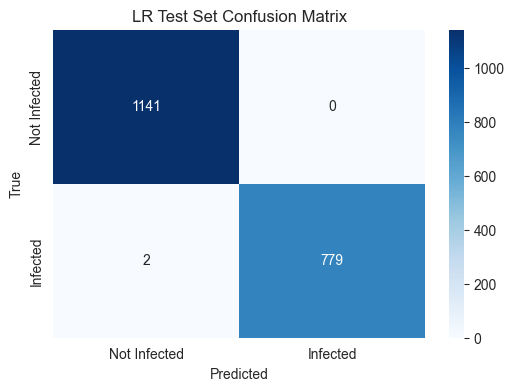


--- Evaluating Random Forest on Actual Test Set ---
Test Accuracy: 1.0000
Test AUC Score: 1.0000

Test Classification Report:
               precision    recall  f1-score   support

Not Infected       1.00      1.00      1.00      1141
    Infected       1.00      1.00      1.00       781

    accuracy                           1.00      1922
   macro avg       1.00      1.00      1.00      1922
weighted avg       1.00      1.00      1.00      1922


Test Confusion Matrix:
[[1141    0]
 [   0  781]]


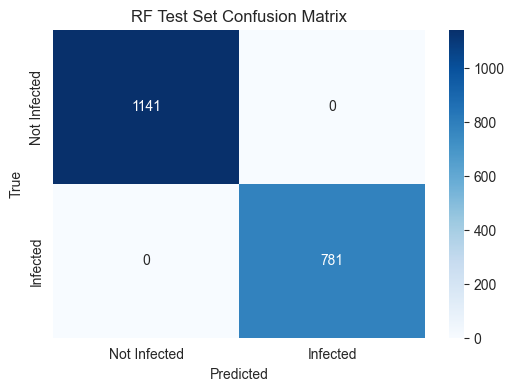

In [30]:
# Ensure necessary metrics functions are imported from sklearn.metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import seaborn as sns # Ensure seaborn/matplotlib are imported for plots

if test_feature_extraction_possible and not df_test_features.empty:
    print("\n--- Scaling test features ---")
    # IMPORTANT: Use the 'scaler' object that was FIT ON THE TRAINING DATA
    # Ensure 'scaler' is available in your notebook memory from previous steps
    X_test_final_scaled = scaler.transform(df_test_features)
    print("Test features scaled.")

    # --- Evaluate Logistic Regression on Test Set ---
    print("\n--- Evaluating Logistic Regression on Actual Test Set ---")
    # IMPORTANT: Use the 'log_reg' model FIT ON THE TRAINING DATA
    y_pred_test_lr = log_reg.predict(X_test_final_scaled)
    y_prob_test_lr = log_reg.predict_proba(X_test_final_scaled)[:, 1]

    print(f"Test Accuracy: {accuracy_score(y_test_actual, y_pred_test_lr):.4f}")
    print(f"Test AUC Score: {roc_auc_score(y_test_actual, y_prob_test_lr):.4f}")
    print("\nTest Classification Report:\n", classification_report(y_test_actual, y_pred_test_lr, target_names=['Not Infected', 'Infected'])) # Assuming 0 is Not Infected, 1 is Infected
    print("\nTest Confusion Matrix:")
    cm_test_lr = confusion_matrix(y_test_actual, y_pred_test_lr)
    print(cm_test_lr)
    # Optional: Plot confusion matrix
    plt.figure(figsize=(6,4)); sns.heatmap(cm_test_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Infected', 'Infected'], yticklabels=['Not Infected', 'Infected']); plt.title('LR Test Set Confusion Matrix'); plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()


    # --- Evaluate Random Forest on Test Set ---
    print("\n--- Evaluating Random Forest on Actual Test Set ---")
    # IMPORTANT: Use the 'rf_clf' model FIT ON THE TRAINING DATA
    y_pred_test_rf = rf_clf.predict(X_test_final_scaled)
    y_prob_test_rf = rf_clf.predict_proba(X_test_final_scaled)[:, 1]

    print(f"Test Accuracy: {accuracy_score(y_test_actual, y_pred_test_rf):.4f}")
    print(f"Test AUC Score: {roc_auc_score(y_test_actual, y_prob_test_rf):.4f}")
    print("\nTest Classification Report:\n", classification_report(y_test_actual, y_pred_test_rf, target_names=['Not Infected', 'Infected']))
    print("\nTest Confusion Matrix:")
    cm_test_rf = confusion_matrix(y_test_actual, y_pred_test_rf)
    print(cm_test_rf)
    # Optional: Plot confusion matrix
    plt.figure(figsize=(6,4)); sns.heatmap(cm_test_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Infected', 'Infected'], yticklabels=['Not Infected', 'Infected']); plt.title('RF Test Set Confusion Matrix'); plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()

else:
    print("\nSkipping test set evaluation for feature models as test features were not extracted.")

Found 781 infected images in training set.
Found 1143 not infected images in training set.


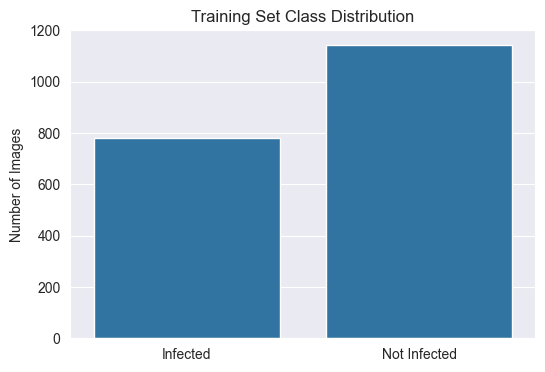


Displaying random sample images...


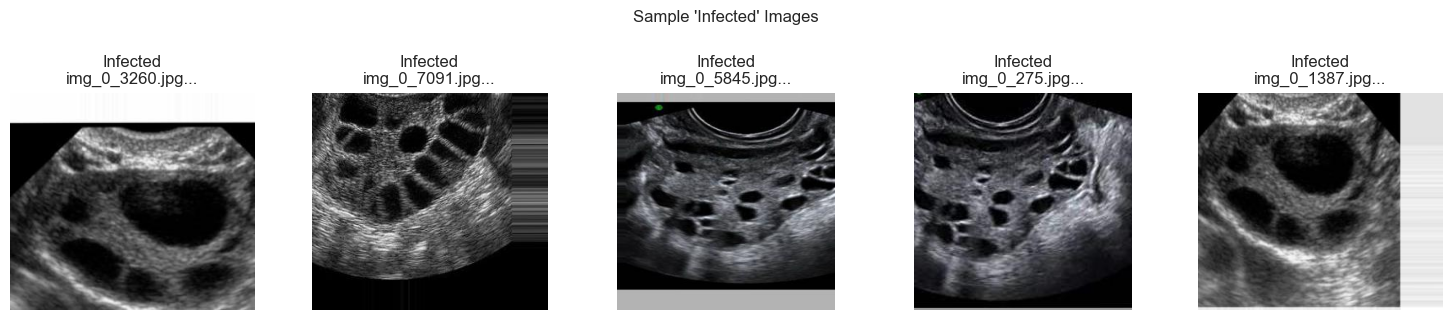

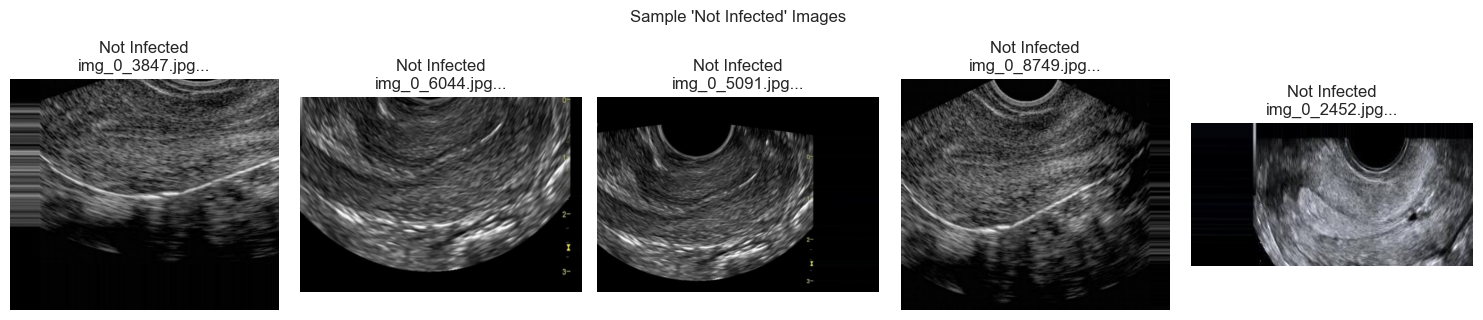


Plotting example pixel histograms...


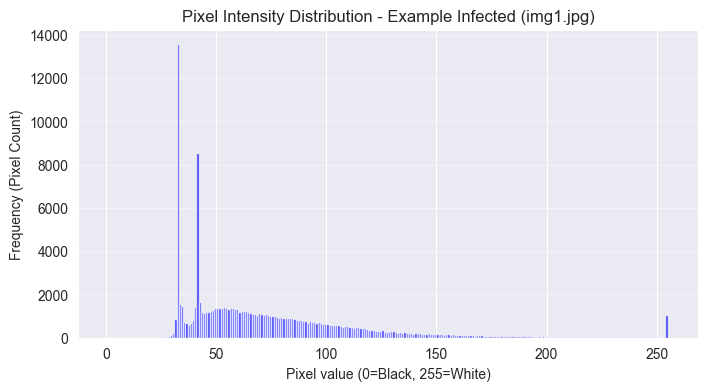

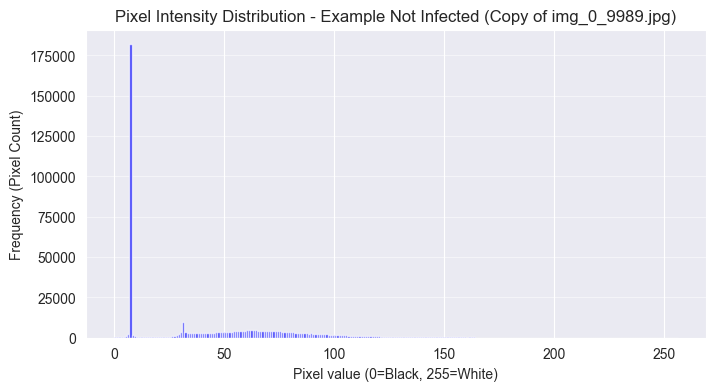

In [29]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from collections import Counter
import seaborn as sns
import random # Import random for selecting random images

# --- Configuration ---
# !! Make sure these paths are correct for your setup !!
infected_dir = '../data/archive/data/train/infected'
notinfected_dir = '../data/archive/data/train/notinfected'

# --- Load File Lists ---
try:
    infected_images = os.listdir(infected_dir)
    notinfected_images = os.listdir(notinfected_dir)
    # Filter out potential non-file entries like subdirectories if any exist
    infected_images = [f for f in infected_images if os.path.isfile(os.path.join(infected_dir, f))]
    notinfected_images = [f for f in notinfected_images if os.path.isfile(os.path.join(notinfected_dir, f))]
    print(f"Found {len(infected_images)} infected images in training set.")
    print(f"Found {len(notinfected_images)} not infected images in training set.")
    paths_valid = True
except FileNotFoundError:
    print("Error: One or both training directories not found. Please check paths:")
    print(f"  - Infected dir checked: {infected_dir}")
    print(f"  - Not infected dir checked: {notinfected_dir}")
    paths_valid = False

if paths_valid and infected_images and notinfected_images: # Proceed only if paths are valid and lists are not empty

    # --- Plot 1: Class Distribution ---
    plt.figure(figsize=(6, 4))
    sns.barplot(x=['Infected', 'Not Infected'], y=[len(infected_images), len(notinfected_images)])
    plt.title("Training Set Class Distribution")
    plt.ylabel("Number of Images")
    plt.show()

    # --- Plot 2: Sample Visualization ---
    def show_random_images(image_files, directory, label, n=5):
        plt.figure(figsize=(15, 3))
        # Ensure we don't request more images than available
        num_to_show = min(n, len(image_files))
        if num_to_show == 0:
            print(f"No images found in {directory} to display.")
            return
        # Select random samples
        sample_files = random.sample(image_files, num_to_show)
        for i, fname in enumerate(sample_files):
            try:
                img_path = os.path.join(directory, fname)
                img = Image.open(img_path)
                plt.subplot(1, num_to_show, i + 1)
                plt.imshow(img, cmap='gray') # Display in grayscale if they are single channel
                plt.title(f"{label}\n{fname[:15]}...") # Show truncated filename
                plt.axis('off')
            except Exception as e:
                print(f"Error loading/displaying {fname}: {e}")
                plt.subplot(1, num_to_show, i + 1)
                plt.title(f"Error loading\n{fname[:15]}...")
                plt.axis('off')
        plt.suptitle(f"Sample '{label}' Images", y=1.05)
        plt.tight_layout()
        plt.show()

    print("\nDisplaying random sample images...")
    show_random_images(infected_images, infected_dir, "Infected", n=5)
    show_random_images(notinfected_images, notinfected_dir, "Not Infected", n=5)

    # --- Plot 3 & 4: Pixel Intensity Histograms ---
    def plot_pixel_distribution(img_path, title):
        try:
            img = Image.open(img_path).convert('L') # Convert to grayscale
            img_array = np.array(img)
            plt.figure(figsize=(8, 4))
            plt.hist(img_array.ravel(), bins=256, range=(0, 256), color='blue', alpha=0.7)
            plt.title(f'Pixel Intensity Distribution - {title}')
            plt.xlabel('Pixel value (0=Black, 255=White)')
            plt.ylabel('Frequency (Pixel Count)')
            plt.grid(axis='y', alpha=0.5)
            plt.show()
        except Exception as e:
            print(f"Could not plot histogram for {img_path}: {e}")

    print("\nPlotting example pixel histograms...")
    # Plot for the first image in each list (or handle if list is empty)
    if infected_images:
        plot_pixel_distribution(os.path.join(infected_dir, infected_images[0]), f"Example Infected ({infected_images[0]})")
    else:
        print("No infected images to plot histogram for.")

    if notinfected_images:
        plot_pixel_distribution(os.path.join(notinfected_dir, notinfected_images[0]), f"Example Not Infected ({notinfected_images[0]})")
    else:
        print("No notinfected images to plot histogram for.")

else:
    print("\nSkipping plot generation due to invalid paths or empty image lists.")

In [31]:
!pip freeze > requirements.txt
